In [1]:
import numpy as np

import utils.network as network_class
import utils.lstm_model as lstm_model_class
import utils.model_trainer as model_trainer_class
import utils.data_processer as data_processer_functions

import torch
import torch.nn as nn

from importlib import reload
from tqdm import trange
from pprint import pprint
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print('CUDA Version', torch.version.cuda)
print('PyTorch Version', torch.__version__)

NVIDIA GeForce RTX 2080 Ti
CUDA Version 11.3
PyTorch Version 1.12.1


# Define Network 

### Network Level Parameters

In [3]:
num_nodes = 5
num_edges = 5

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1,0,0,0,0], # -1 => node is edge's source
                                [1,-1,-1,0,0], # 1 => node is edge's destination
                                [0,1,0,-1,0],
                                [0,0,1,1,-1],
                                [0,0,0,0,1]])

### Tunnel Level Parameters

In [4]:
num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,0,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[0,:]  = np.array([1,0,0,0,0])
underlay_service_rates[0,:] = np.array([0,1,0,1,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,1,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[1,:]  = np.array([1,0,0,0,0])
underlay_service_rates[1,:] = np.array([0,0,1,0,1])

### Get Network Class

In [5]:
reload(network_class)
my_network = network_class.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel, 
    underlay_service_rates,
    external_arrival_rates)

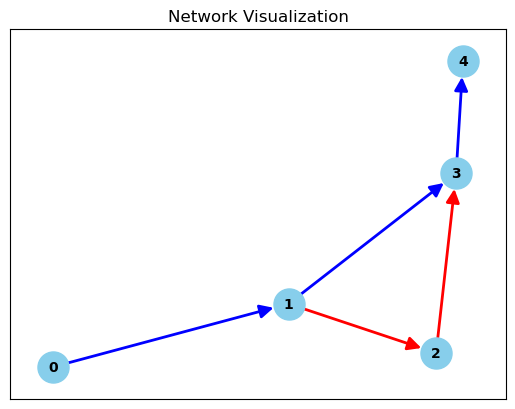

In [6]:
my_network.visualize(custom_seed = 1)

# Simulate Network

In [7]:
packets_in_flight, tunnel_backlogs = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)

# Model Training

In [8]:
def prepare_data(device, tunnel_backlogs, packets_in_flight, look_back):
    # class to split data, scale data, and rescale data
    data_processer = data_processer_functions.DataProcessor()

    # create time series sequences with given look_back hyperparameter
    x_all = data_processer.create_sequences(torch.Tensor(packets_in_flight), look_back).to(device)
    y_all = torch.Tensor(tunnel_backlogs).to(device)
    
    # feature engineering
    x_transformed = data_processer.feature_transform(device, x_all)

    # split into train and test
    x_train_unscaled, y_train_unscaled, x_test_unscaled, y_test_unscaled = data_processer.split_train_test(x_transformed, y_all)

    # rescale to [0,1]
    x_train, y_train = data_processer.scale_train(x_train_unscaled, y_train_unscaled, is_x_sequenced = True)
    x_test, y_test = data_processer.scale_test(x_test_unscaled, y_test_unscaled)

    return data_processer, x_train, y_train, x_test, y_test

In [9]:
def define_and_train_model(device, hidden_sizes, learning_rate, num_epochs, x_train, y_train):
    # seeds  for reproducibility
    np.random.seed(0)
    torch.manual_seed(0)

    # define model with given hidden_sizes
    input_size  = x_train.shape[-1]
    output_size = y_train.shape[-1]
    lstm_predictor = lstm_model_class.LSTMModel(input_size, hidden_sizes, output_size).to(device)

    # define tools for training with given hyperparameters
    trainer = model_trainer_class.modelTrainer(criterion = nn.MSELoss(), device = device)
    optimizer = torch.optim.Adam(lstm_predictor.parameters(), lr = learning_rate)

    # training loop
    pbar = trange(num_epochs)
    for epoch in pbar:
        # perform a training epoch using full x_train dataset
        # (future): if x_train is too large, break into batches, and use batches x_batch instead 
        loss_value = trainer.batch_step(lstm_predictor, x_train, y_train, optimizer) 
        pbar.set_postfix({'epoch': f'{epoch+1}/{num_epochs}', 'loss': loss_value, 'look_back': x_train.shape[1], 'hidden_sizes': str(hidden_sizes), 'learning_rate': learning_rate})

    return lstm_predictor

In [10]:
def get_error_rates(lstm_predictor, x, y, data_processer):
    # get predictions
    lstm_predictor.eval()
    y_pred = lstm_predictor.evaluate(x)

    # rescale back to queue sizes
    _, y_pred_unscaled = data_processer.inverse_scale(x_scaled=0, y_scaled=y_pred)
    _, y_unscaled = data_processer.inverse_scale(x_scaled=0, y_scaled=y)
    y_pred_unscaled = np.round(y_pred_unscaled.cpu().numpy())
    y_unscaled = y_unscaled.cpu().numpy()

    # calculate root mean squared error, and max absolute percentage error
    rmse = mean_squared_error(y_unscaled, y_pred_unscaled, squared = False) # rms = np.sqrt(np.mean((Y_predicted-Y)**2))
    mape = mean_absolute_percentage_error(y_unscaled[y_unscaled>0], y_pred_unscaled[y_unscaled>0])*100 # mape = 100*np.mean(np.abs(y_pred_unscaled-y_unscaled)[y_unscaled>0]/y_unscaled[y_unscaled>0])

    error_rates = {'rmse': rmse,
                   'mape': mape}

    return error_rates, y_unscaled, y_pred_unscaled

In [11]:
def train_model_and_get_performance(device, tunnel_backlogs, packets_in_flight, look_back, hidden_sizes, learning_rate, num_epochs):
    # prepare data
    data_processer, x_train, y_train, x_test, y_test = prepare_data(device, tunnel_backlogs, packets_in_flight, look_back)

    # define and train model
    lstm_predictor = define_and_train_model(device, hidden_sizes, learning_rate, num_epochs, x_train, y_train)

    # get performance metrics
    train_error_rates, _, _ = get_error_rates(lstm_predictor, x_train, y_train, data_processer)
    test_error_rates, _, _ = get_error_rates(lstm_predictor, x_test, y_test, data_processer)
    error_metrics = {'train': train_error_rates, 'test': test_error_rates}
    
    return lstm_predictor, error_metrics

In [12]:
reload(data_processer_functions)
reload(lstm_model_class)
reload(model_trainer_class)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create hyperparamer lists to explore
look_back_list = [10]
hidden_sizes_list = [[10,20,10,5], [5,5,5]]
learning_rate_list = [1e-2] #[5e-2, 1e-2, 5e-3]
num_epochs = 250
saved_models = []

for look_back in look_back_list:
    for hidden_sizes in hidden_sizes_list:
        for learning_rate in learning_rate_list:
            # train and test the model
            model, error_metrics = train_model_and_get_performance(device, tunnel_backlogs, packets_in_flight, look_back, hidden_sizes, learning_rate, num_epochs)

            # save trained model
            saved_models.append({
                        'model' : model,
                        'look_back': look_back,
                        'learning_rate': learning_rate,
                        'hidden_size' : hidden_sizes,
                        'error_metrics': error_metrics
                    })
            
# sort models according to best test rmse error
saved_models.sort(key = lambda x: (x['error_metrics']['test']['rmse'], x['error_metrics']['test']['mape'])) # (future): technically should have validation data and sort according to that 

100%|██████████| 250/250 [00:16<00:00, 14.83it/s, epoch=250/250, loss=0.00162, look_back=10, hidden_sizes=[5, 5, 5], learning_rate=0.01]


In [13]:
print('Best model:', f'[{datetime.now().strftime("%d/%m/%Y %H:%M:%S")}]')
pprint(saved_models[0])

Best model: [10/12/2023 17:24:24]
{'error_metrics': {'test': {'mape': 8.052066713571548, 'rmse': 4.981002},
                   'train': {'mape': 8.57267752289772, 'rmse': 5.755376}},
 'hidden_size': [5, 5, 5],
 'learning_rate': 0.01,
 'look_back': 10,
 'model': LSTMModel(
  (hidden_layers): ModuleList(
    (0): LSTM(5, 5, batch_first=True)
    (1): LSTM(5, 5, batch_first=True)
    (2): LSTM(5, 5, batch_first=True)
  )
  (output_layer): Linear(in_features=5, out_features=2, bias=True)
)}


In [14]:
look_back = saved_models[0]['look_back']

# prepare data
data_processer, x_train, y_train, x_test, y_test = prepare_data(device, tunnel_backlogs, packets_in_flight, look_back)

# define and train model
lstm_predictor = saved_models[0]['model']

# get performance metrics
train_error_rates, _, _ = get_error_rates(lstm_predictor, x_train, y_train, data_processer)
test_error_rates, y, y_pred = get_error_rates(lstm_predictor, x_test, y_test, data_processer)
error_metrics = {'train': train_error_rates, 'test': test_error_rates}

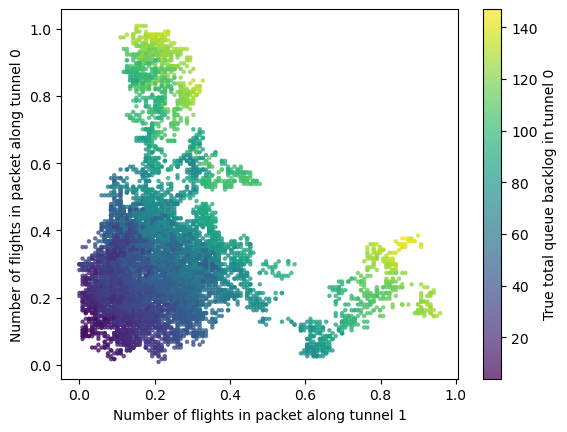

In [15]:
import matplotlib.pyplot as plt
plt.scatter(x_test[:,-1,:].cpu().numpy()[:, 1], x_test[:,-1,:].cpu().numpy()[:, 0], c = y[:,1], cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Number of flights in packet along tunnel 1')
plt.ylabel('Number of flights in packet along tunnel 0')
cbar = plt.colorbar()
cbar.set_label('True total queue backlog in tunnel 0')

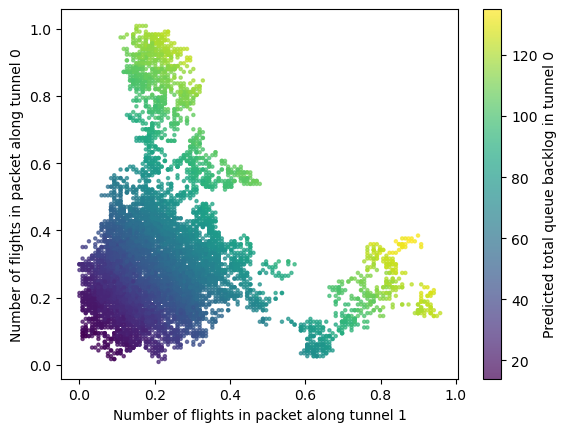

In [16]:
import matplotlib.pyplot as plt
plt.scatter(x_test[:,-1,:].cpu().numpy()[:, 1], x_test[:,-1,:].cpu().numpy()[:, 0], c = y_pred[:,1], cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Number of flights in packet along tunnel 1')
plt.ylabel('Number of flights in packet along tunnel 0')
cbar = plt.colorbar()
cbar.set_label('Predicted total queue backlog in tunnel 0')